# LCLIB Example

In this notebook we look at how we could take light curves from a LCLIB file and simulate them under different observing cadences and noise conditions.

In [1]:
import numpy as np

from tdastro.astro_utils.passbands import PassbandGroup
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.math_nodes.ra_dec_sampler import OpSimRADECSampler
from tdastro.opsim.opsim import OpSim
from tdastro.simulate import simulate_lightcurves
from tdastro.sources.lightcurve_source import MultiLightcurveSource
from tdastro.utils.plotting import plot_lightcurves

from tdastro import _TDASTRO_BASE_DATA_DIR

## Load Data Files

We start by loading the files we will need for running the simulation: the OpSim database and the passband information. Both of these live in the `data/` directory in the root directory. Note that nothing in this directory is saved to github, so the files might have to be downloaded initially.

For Rubin, a large number of OpSims can be found at [https://s3df.slac.stanford.edu/data/rubin/sim-data/](https://s3df.slac.stanford.edu/data/rubin/sim-data/). You can download an OpSim manually or using the `from_url()` helper function:

> opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/baseline/baseline_v3.4_10yrs.db"

> opsim_data = OpSim.from_url(opsim_url)

We only care about the observations in the OpSim in the filters we wish to simulate. So we use `OpSim.filter_rows()` to remove those rows that do not match.

In [2]:
# Choose which filters to simulate.
filters = ["g", "r", "i", "z"]

# Load the OpSim data.
opsim_db = OpSim.from_db(_TDASTRO_BASE_DATA_DIR / "opsim" / "baseline_v3.4_10yrs.db")
print(f"Loaded OpSim with {len(opsim_db)} rows.")

# Filter to only the rows that match the filters we want to simulate.
filter_mask = np.isin(opsim_db["filter"], filters)
opsim_db = opsim_db.filter_rows(filter_mask)

# Print the number of rows and time bounds after filtering.
t_min, t_max = opsim_db.time_bounds()
print(f"Filtered OpSim to {len(opsim_db)} rows and times [{t_min}, {t_max}]")

Loaded OpSim with 2146797 rows.
Filtered OpSim to 1630613 rows and times [60796.00143922635, 64448.429406568604]


Load the passband information, using the same filters.

2025-06-25 16:07:49,080 - INFO - Loading passbands from preset LSST
2025-06-25 16:07:49,082 - INFO - Data file /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/u.dat already exists. Skipping download.
2025-06-25 16:07:49,082 - INFO - Loading passband from file: /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/u.dat
2025-06-25 16:07:49,088 - INFO - Data file /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/g.dat already exists. Skipping download.
2025-06-25 16:07:49,088 - INFO - Loading passband from file: /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/g.dat
2025-06-25 16:07:49,092 - INFO - Data file /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/r.dat already exists. Skipping download.
2025-06-25 16:07:49,093 - INFO - Loading passband from file: /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/r.dat
2025-06-25 16:07:49,098 - INFO - Data file /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/i.dat already exists. Skipping download.
2025-06-25 16:07:49,098 - INFO - Loading pass

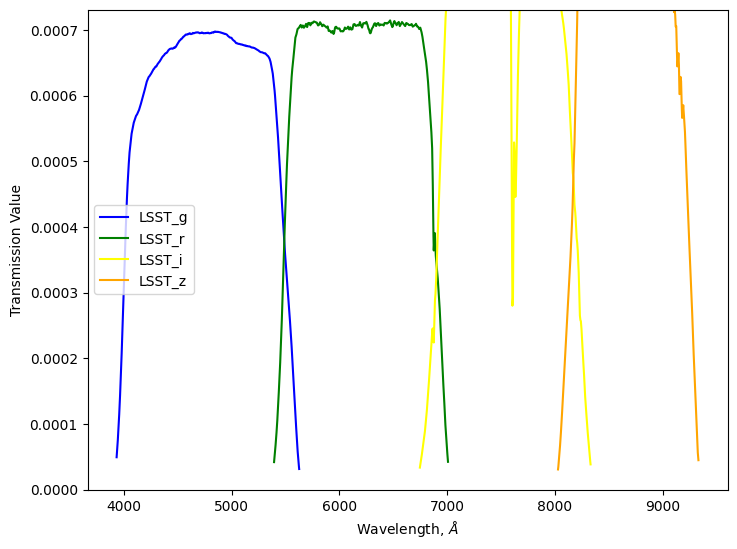

In [3]:
# Load the passband data for the griz filters only.
table_dir = _TDASTRO_BASE_DATA_DIR / "passbands" / "LSST"
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    filters=filters,
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
    table_dir=table_dir,
)
passband_group.plot()

## Create the model

We want to create models based on an existing LCLIB file. Again we will need to download the file of interest to the data directory.  In this example we use the LCLIB_RRL-LSST.TEXT.gz data from https://zenodo.org/records/6672739.  We load this into a `MultiLightcurveSource` object, which represents a set of light curves from which we can sample.

Since `MultiLightcurveSource` is a `PhysicalModel`, we can specify other parameters such as the RA and dec.  We generate this position information by sampling from the OpSim fields. We sample the starting time of the light curve uniformly from the time covered by the OpSim.

In [4]:
lc_file = _TDASTRO_BASE_DATA_DIR / "models" / "LCLIB_RRL-LSST.TEXT.gz"

# Use an OpSim based sampler for position.
ra_dec_sampler = OpSimRADECSampler(
    opsim_db,
    radius=3.0,  # degrees
    node_label="ra_dec_sampler",
)

# Use a uniform sampler for time.
time_sampler = NumpyRandomFunc("uniform", low=t_min, high=t_max, node_label="time_sampler")

# Load the light curves from the LCLIB file. Only load the filters that are present in the OpSim data.
source = MultiLightcurveSource.from_lclib_file(
    lc_file,
    passband_group,
    ra=ra_dec_sampler.ra,
    dec=ra_dec_sampler.dec,
    t0=time_sampler,
    filters=filters,
    node_label="source",
)

print(f"Loaded {len(source)} light curves from {lc_file}")

Loaded 49130 light curves from /Users/jkubica/h/tdastro/data/models/LCLIB_RRL-LSST.TEXT.gz


## Generate the simulations

We can now generate random simulations with all the information defined above. The light curves are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. 

In [5]:
lightcurves = simulate_lightcurves(source, 1_000, opsim_db, passband_group)
print(lightcurves)

      id          ra        dec  nobs     z  \
0      0   45.033818  11.538293   193  None   
1      1  272.274578 -52.978155   679  None   
..   ...         ...        ...   ...   ...   
998  998  189.209585 -15.345971   616  None   
999  999  138.890940  23.794456   213  None   

                                                params  \
0    {'ra_dec_sampler.ra': 45.03381754307749, 'ra_d...   
1    {'ra_dec_sampler.ra': 272.2745778847292, 'ra_d...   
..                                                 ...   
998  {'ra_dec_sampler.ra': 189.20958454944227, 'ra_...   
999  {'ra_dec_sampler.ra': 138.89094015459068, 'ra_...   

                                            lightcurve  
0    [{mjd: 60966.302331, filter: 'r', flux: 461008...  
1    [{mjd: 60807.289437, filter: 'i', flux: 114125...  
..                                                 ...  
998  [{mjd: 60796.315368, filter: 'g', flux: 384087...  
999  [{mjd: 60847.951944, filter: 'i', flux: 1.3152...  

[1000 rows x 7 columns]


Now let's plot some random light curves. Note that all of the light curves in the "LCLIB_RRL-LSST.TEXT.gz" file are periodic, so we expect to see observations throughout the time range of the survey.

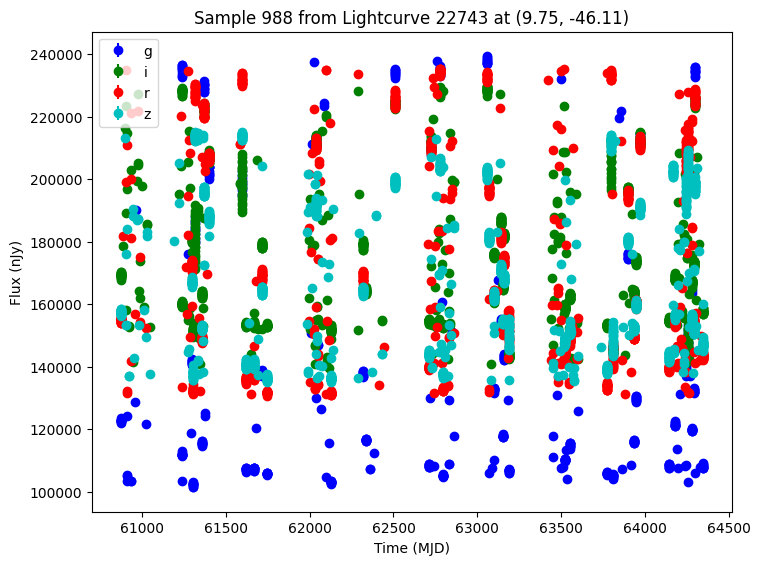

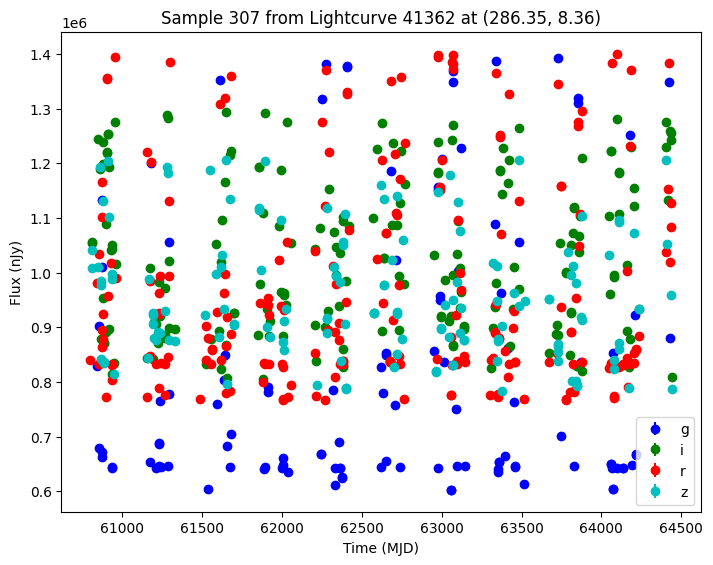

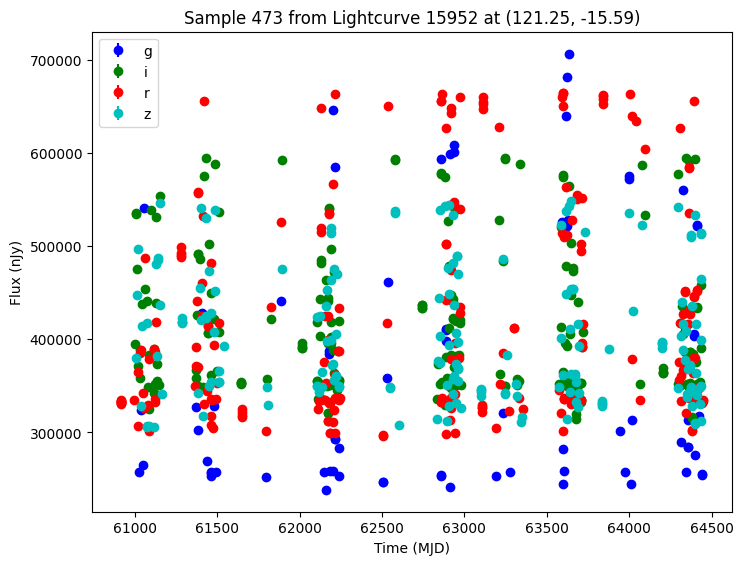

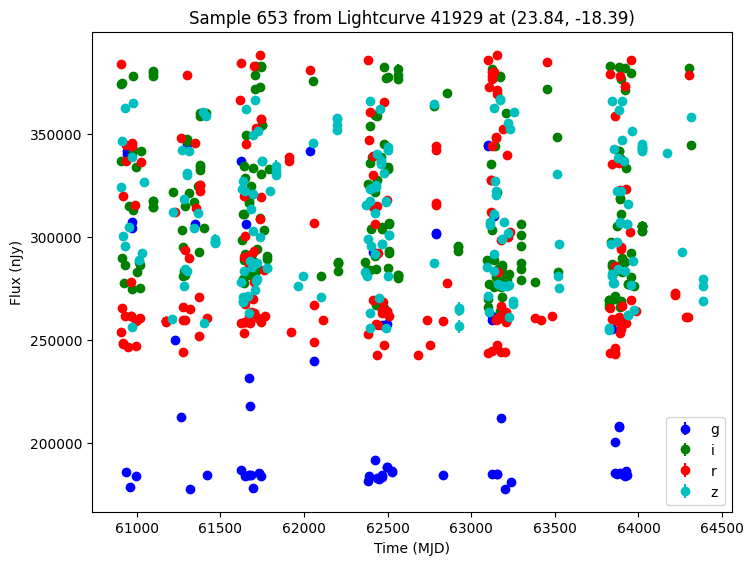

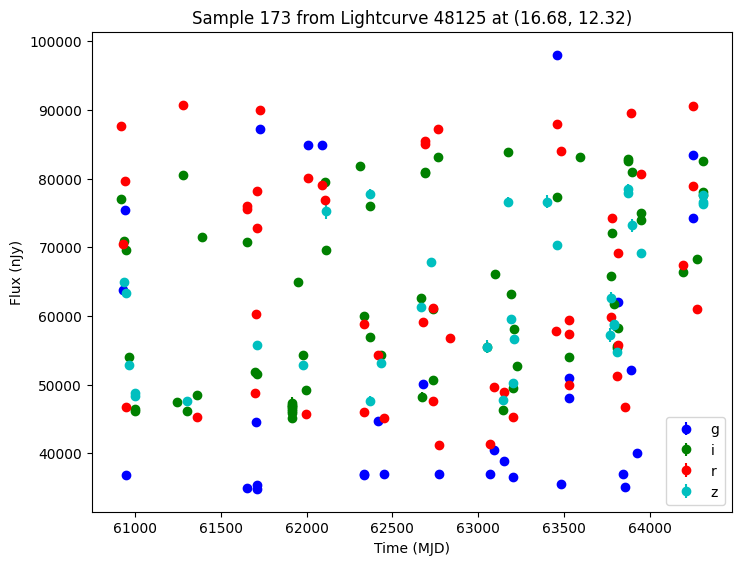

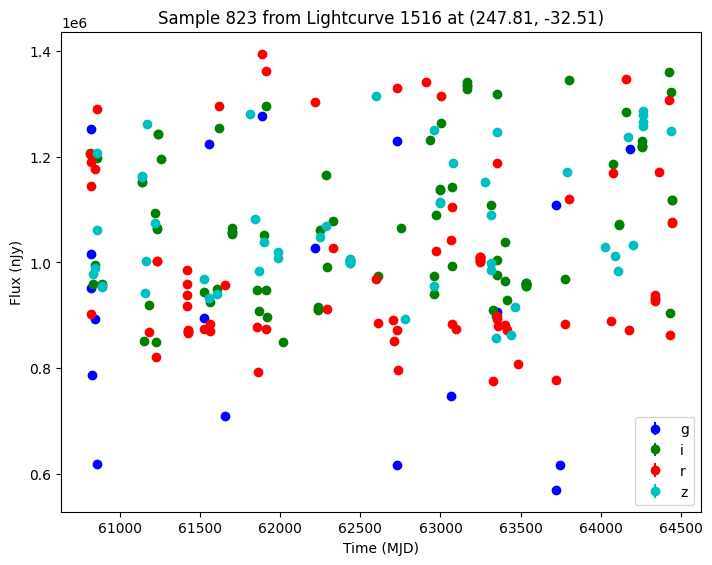

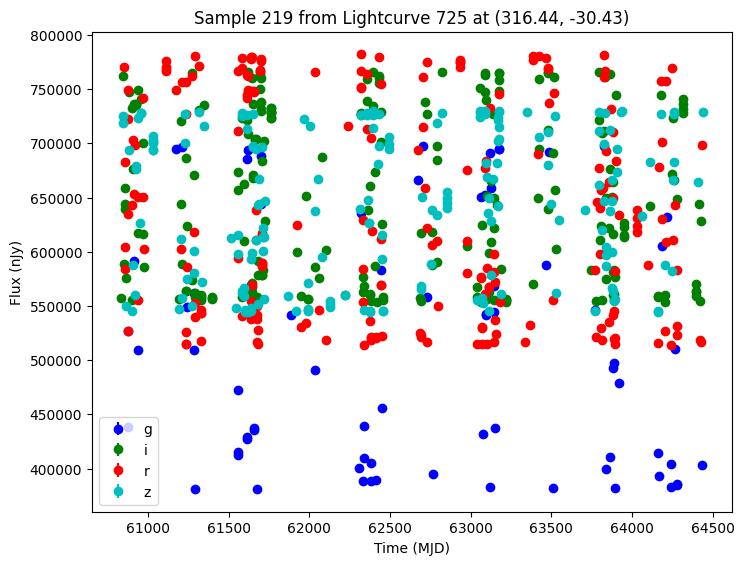

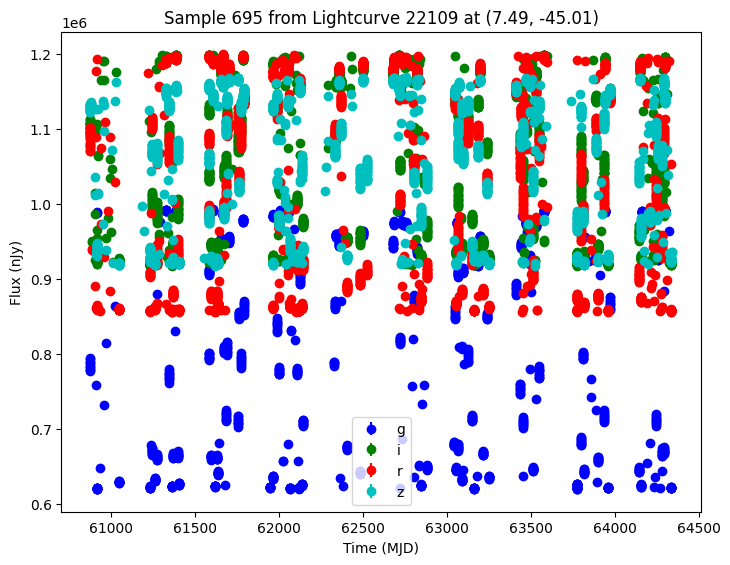

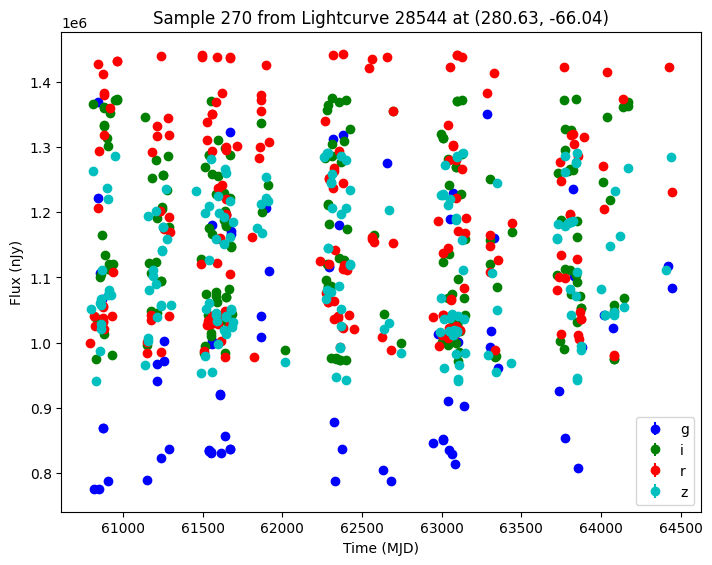

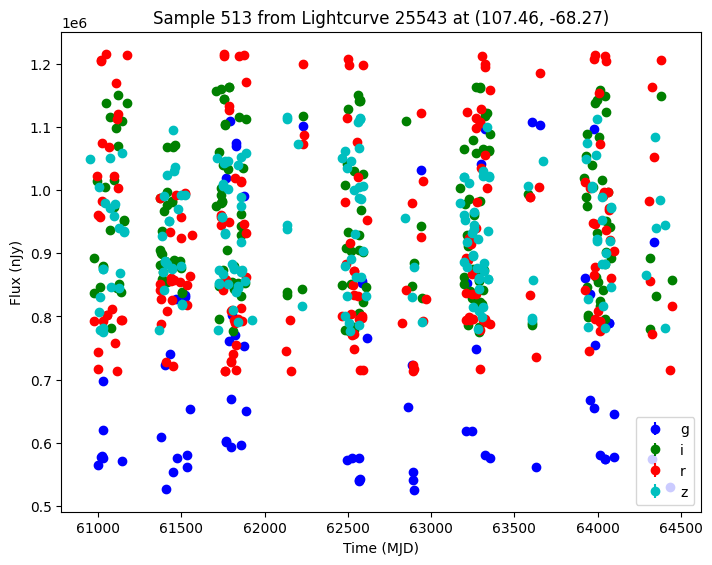

In [6]:
random_ids = np.random.choice(len(lightcurves), 10)

for random_id in random_ids:
    # Extract the row for this object.
    lc = lightcurves.loc[random_id]

    if lc["nobs"] > 0:
        # Unpack the nested columns (filters, mjd, flux, and flux error).
        lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
        lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
        lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
        lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

        # Look up which lightcurve was used.
        graph_state = lc["params"]
        lc_id = graph_state["source.selected_lightcurve"]
        ra = graph_state["source.ra"]
        dec = graph_state["source.dec"]

        plot_lightcurves(
            fluxes=lc_flux,
            times=lc_mjd,
            fluxerrs=lc_fluxerr,
            filters=lc_filters,
            title=f"Sample {random_id} from Lightcurve {lc_id} at ({ra:.2f}, {dec:.2f})",
        )